In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from NegativeClassOptimization import config
import seaborn as sns
import matplotlib.pyplot as plt
from NegativeClassOptimization.preprocessing import *

In [3]:
df_affmat = pd.read_csv(config.DATA_POREBSKI_AFFMAT)
df_mllib = pd.read_csv(config.DATA_POREBSKI_MLLIB)

In [4]:
fp = "01b_df_kd.csv"
df_kd = pd.read_csv(fp)

In [5]:
th_non_weak = 122
th_weak_high = 150

df_kd["binder_type"] = "HR2P_95low"
df_kd.loc[df_kd["intensity 8"] > th_weak_high, "binder_type"] = "HR2P_high"
df_kd.loc[
    (df_kd["intensity 8"] > th_non_weak) & ((df_kd["intensity 8"] <= th_weak_high)),
    "binder_type",
] = "HR2P_looserX"

print(df_kd["binder_type"].value_counts())
df_kd.head()

HR2P_95low      18578
HR2P_looserX     3574
HR2P_high        2638
Name: binder_type, dtype: int64


,Unnamed: 0,cdr3,Kd_est,E_est,F_min,F_max,intensity 0,intensity 1,intensity 10,intensity 11,...,intensity 2,intensity 3,intensity 4,intensity 5,intensity 6,intensity 7,intensity 8,intensity 9,affinity_est,binder_type
0,0,ADVAYCCTPTCAKWPEYFQWW,2.566097e-07,-36.989043,94.461716,141.05211,111.342196,108.361792,117.222275,117.295862,...,107.364475,113.558279,110.967933,111.959556,119.406109,126.040790,118.581446,118.161568,3.896969e+06,HR2P_95low
1,1,CDGACCDTPTCAKWPEYFQHW,3.757516e-07,-36.059492,93.957440,144.95908,110.953692,108.887190,113.325916,114.728697,...,112.172095,111.951280,113.303819,113.053718,113.291626,117.351588,113.952191,113.828101,2.661333e+06,HR2P_95low
2,2,CDPAYYSSSRCLTWPEYFQHW,3.962092e-07,-35.930277,94.155020,149.19969,109.530200,110.394295,112.850615,111.254278,...,109.994383,110.328671,110.611589,113.414645,113.032409,117.512647,114.270451,112.941200,2.523919e+06,HR2P_95low
3,3,CDRAYCDTPTCAKWPEYFQHW,4.037524e-07,-35.884309,96.954380,133.01643,109.273767,110.639957,117.067877,112.947864,...,109.797395,107.939179,111.938496,113.410432,116.078040,116.459165,113.967739,114.493203,2.476765e+06,HR2P_95low
4,4,CDRAYCDTPTCAKWPEYFQPW,3.318797e-07,-36.362107,91.821106,142.25514,110.699016,109.528347,112.976801,112.402118,...,110.135047,109.945588,111.109728,112.412832,114.181798,116.347380,113.271742,114.328324,3.013140e+06,HR2P_95low


In [6]:
### Adapt df to fit as much as possible
### the format we used with Absolut data.
# ID_slide_Variant	CDR3	Best	Slide	Energy	Structure	Source	Antigen
df_kd["ID_slide_Variant"] = None
df_kd["CDR3"] = df_kd["cdr3"]
df_kd["Best"] = True
df_kd["Slide"] = df_kd["cdr3"]
df_kd["Energy"] = df_kd["intensity 8"]
df_kd["Structure"] = None
df_kd["Source"] = df_kd["binder_type"]
df_kd["Antigen"] = "HR2P"
df_kd = df_kd[["ID_slide_Variant", "CDR3", "Best", "Slide", "Energy", "Structure", "Source", "Antigen", "binder_type"]].copy()

# Check no duplicates
assert df_kd["CDR3"].duplicated().sum() == 0, "There are duplicated CDR3s"

In [7]:
df_kd.head()

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,Source,Antigen,binder_type
0,None,ADVAYCCTPTCAKWPEYFQWW,True,ADVAYCCTPTCAKWPEYFQWW,118.581446,None,HR2P_95low,HR2P,HR2P_95low
1,None,CDGACCDTPTCAKWPEYFQHW,True,CDGACCDTPTCAKWPEYFQHW,113.952191,None,HR2P_95low,HR2P,HR2P_95low
2,None,CDPAYYSSSRCLTWPEYFQHW,True,CDPAYYSSSRCLTWPEYFQHW,114.270451,None,HR2P_95low,HR2P,HR2P_95low
3,None,CDRAYCDTPTCAKWPEYFQHW,True,CDRAYCDTPTCAKWPEYFQHW,113.967739,None,HR2P_95low,HR2P,HR2P_95low
4,None,CDRAYCDTPTCAKWPEYFQPW,True,CDRAYCDTPTCAKWPEYFQPW,113.271742,None,HR2P_95low,HR2P,HR2P_95low


In [8]:
#N train 5000 seq in total, 2500 + and 2500+ neg, then split 42

df_kd.binder_type.value_counts()

HR2P_95low      18578
HR2P_looserX     3574
HR2P_high        2638
Name: binder_type, dtype: int64

In [9]:
#We take 2500 positives
df_pos = df_kd[df_kd['binder_type'] == 'HR2P_high'].sample(n=2500, random_state=42)
df_pos['y'] = 1
df_weak = df_kd[df_kd['binder_type'] == 'HR2P_looserX'].sample(n=2500, random_state=42)
df_weak['y'] = 0
df_nb = df_kd[df_kd['binder_type'] == 'HR2P_95low'].sample(n=2500, random_state=42)
df_nb['y'] = 0


In [10]:
from sklearn.model_selection import train_test_split
df_pos_train, df_pos_test = train_test_split(df_pos, test_size=0.2, random_state=42)
df_weak_train, df_weak_test = train_test_split(df_weak, test_size=0.2, random_state=42)
df_nb_train, df_nb_test = train_test_split(df_nb, test_size=0.2, random_state=42)

In [11]:
df_vs_weak_train = pd.concat([df_pos_train, df_weak_train]).reset_index(drop=True)
df_vs_weak_test = pd.concat([df_pos_test, df_weak_test]).reset_index(drop=True)
df_vs_nb_train = pd.concat([df_pos_train, df_nb_train]).reset_index(drop=True)
df_vs_nb_test = pd.concat([df_pos_test, df_nb_test]).reset_index(drop=True)

In [12]:
def find_one_char_diff_pairs(df_train, df_test):
    placeholder = '*'
    seen = {}
    pairs = []

    # Process the first set: store modified sequences with their identifiers
    for train_sequence in df_train['Slide']:
        for i in range(len(train_sequence)):
            modified = train_sequence[:i] + placeholder + train_sequence[i+1:]
            if modified in seen:
                seen[modified].append(train_sequence)
            else:
                seen[modified] = [train_sequence]

    # Process the second set and look for matches in the dictionary
    for test_sequence in df_test['Slide']:
        for i in range(len(test_sequence)):
            modified = test_sequence[:i] + placeholder + test_sequence[i+1:]
            if modified in seen:
                for train_seq in seen[modified]:
                    pairs.append([train_seq, test_sequence])

    return pairs


In [13]:
def get_leak_info(df_train,df_test, pairs):
    train_lookup_dict = df_train.set_index('Slide').to_dict(orient='index')
    test_lookup_dict = df_test.set_index('Slide').to_dict(orient='index')
    leak_info = []
    concordance_dict = {
    '11':'++',
    '00':'--',
    '10':'+-',
    '01':'-+'}
    for train_slide, test_slide in pairs: #mixed up
        train_label = train_lookup_dict[train_slide]['y']
        train_eng = train_lookup_dict[train_slide]['Energy']

        test_label = test_lookup_dict[test_slide]['y']
        test_eng = test_lookup_dict[test_slide]['Energy']
        label_concordance = str(train_label) + str(test_label)
        label_concordance = concordance_dict[label_concordance]
        eng_diff = train_eng - test_eng
        leak_info.append([train_slide, test_slide, label_concordance, eng_diff])
    leak_df = pd.DataFrame(leak_info, columns=['train_Slide', 'test_Slide', 'label_concordance', 'Energy_diff'])
    return leak_df

In [14]:
#leaks on Weak
df_train, df_test = df_vs_weak_train, df_vs_weak_test
pairs = find_one_char_diff_pairs(df_train, df_test)
leak_weak_df = get_leak_info(df_train,df_test, pairs)

#leaks of Non-binder
df_train, df_test = df_vs_nb_train, df_vs_nb_test
pairs = find_one_char_diff_pairs(df_train, df_test)
leak_nb_df = get_leak_info(df_train,df_test, pairs)

In [15]:
def label_concordance_count(leak_df, df_test):
    grouped_counts = leak_df.groupby(['test_Slide','label_concordance']).size().unstack(level=-1, fill_value=0)
    row_sum = grouped_counts.sum(axis=1)
    label_concordance_abundance = grouped_counts.div(row_sum, axis=0)
    label_concordance_abundance = label_concordance_abundance.sum(axis=0)/df_test.shape[0]
    return label_concordance_abundance

In [16]:
label_concordance_abundance_nb = label_concordance_count(leak_nb_df, df_vs_nb_test)
label_concordance_abundance_weak = label_concordance_count(leak_weak_df, df_vs_weak_test)

In [17]:
lc_nb = pd.DataFrame(label_concordance_abundance_nb).T
lc_nb['task'] = 'vs Non-binder'
lc_wk = pd.DataFrame(label_concordance_abundance_weak).T
lc_wk['task'] = 'vs Weak'

In [28]:
lc_nb[['++', '+-', '--', '-+']].apply(sum, axis=1)

0    0.437
dtype: float64

In [29]:
lc_wk[['++', '+-', '--', '-+']].apply(sum, axis=1)

0    0.651
dtype: float64

In [18]:
lc = pd.concat([lc_nb, lc_wk])

In [18]:
col_order = ['++', '--', '+-', '-+', 'task']

In [19]:
task_order =['vs Non-binder', 'vs Weak']

In [20]:
def put_numbers_to_barplt(count_df):
    for i, task in enumerate(task_order):
        base = 0
        for col in col_order[:-1]:
            y = count_df[count_df['task']==task][col].values[0].round(2)
            plt.text(x=i-0.05, y=y/2+base, s=y, size="small")
            base += y

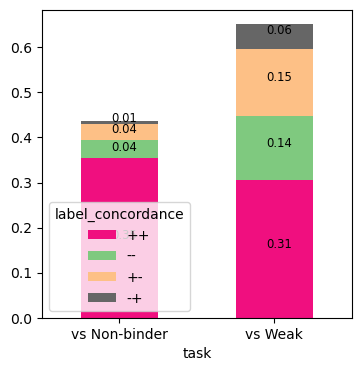

In [21]:
plt.rcParams['svg.fonttype'] = 'none'
lc[col_order].plot(kind='bar', x='task', stacked=True, color=["#F00F7F", "#7FC97F","#FDC086","#666666"], figsize=(4,4)) #colors are wrong
put_numbers_to_barplt(lc[col_order])
plt.xticks(rotation=0)
#color=["#F00F7F", "#7FC97F", "#FDC086","#666666"]#
#cmap={'++':"#F00F7F", '--': "#7FC97F", '+-': "#FDC086", "-+":"#666666"}
plt.savefig('./figures/id-ood-corr-exp.svg')

In [22]:
leak_nb_df['task'] = 'vs Non-binder'
leak_weak_df['task'] = 'vs Weak'
leak_all_df = pd.concat([leak_nb_df, leak_weak_df])

In [23]:
leak_all_df['Energy_diff_abs'] = leak_all_df['Energy_diff'].abs()

In [24]:
def plot_median_for_energy_diff(df, hue_order):
    median_values = df.groupby(['task', 'label_concordance']).median().reset_index()
    n_hues = len(hue_order) # Number of hues
    width_per_group = 1
    for i, row in median_values.iterrows():
        task = row['task']
        label_concordance = row['label_concordance']
        median_value = row['Energy_diff_abs']

        if label_concordance in hue_order:

            task_index = task_order.index(task)
            base_x_position = task_index * width_per_group

            # Calculate the offset for the current hue within the group
            hue_index = hue_order.index(label_concordance)
            hue_offset = (hue_index - (n_hues - 1) / 2) * (width_per_group / n_hues)

            # Final x-position
            x_position = base_x_position + hue_offset
            y_position = -0.4

            # Place the text
            plt.text(x_position, y_position, f'{median_value:.2f}', ha='center', va='top', rotation=90)

In [25]:
hue_order=['++', '--', '+-', '-+']

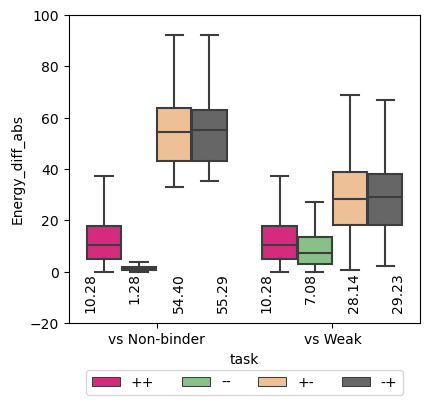

In [26]:
plt.rcParams['svg.fonttype'] = 'none'
plt.figure(figsize=(4*1.134,4))
plt.ylim([-20, 100])
sns.boxplot(leak_all_df, x='task',  y='Energy_diff_abs', hue='label_concordance', showfliers=False,\
            hue_order=hue_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})
plot_median_for_energy_diff(leak_all_df, hue_order)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
plt.savefig('./figures/leak_eng_diff_exp.svg')

In [ ]:
#I don't think we can do performance correlation because there are one independent data point 
#but we can try to add it to synthetic